# 서울시 요식업 평균 매출 예측 모델

필요한 라이브러리 import

In [1]:
# 기본적인 부분
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc("font", family="Malgun Gothic")
plt.rcParams["axes.unicode_minus"]=False

# 데이터 전처리
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import PolynomialFeatures

# 학습 알고리즘
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet

from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report
from scipy.special import expit, softmax

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from scipy.stats import uniform, randint
from sklearn.ensemble import RandomForestClassifier

## 데이터 로드 및 정제

### 서울시 추정매출 데이터

In [2]:
sales_df = pd.read_csv("../data/서울시 상권분석서비스(추정매출-상권).csv", encoding="cp949")

In [3]:
sales_df.head()

,기준_년분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,주중_매출_금액,...,시간대_건수~21_매출_건수,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수
0,20241,U,관광특구,3001491,이태원 관광특구,CS100001,한식음식점,1.185751e+10,254192,6.640829e+09,...,69016,38472,129419,109336,1277,73116,86124,33511,28074,16652
1,20241,U,관광특구,3001491,이태원 관광특구,CS100002,중식음식점,1.911647e+09,46140,1.259317e+09,...,18085,4918,21479,21646,151,14443,15206,5918,4892,2514
2,20241,U,관광특구,3001491,이태원 관광특구,CS100003,일식음식점,7.273213e+08,10811,4.611840e+08,...,3596,2734,4855,4682,52,2911,3636,1345,1222,371
3,20241,U,관광특구,3001491,이태원 관광특구,CS100004,양식음식점,1.673468e+10,414722,8.256458e+09,...,135195,83964,228805,173511,3268,151680,156120,45901,31260,14074
4,20241,U,관광특구,3001491,이태원 관광특구,CS100005,제과점,1.255782e+09,96224,7.704259e+08,...,28562,8063,38105,54368,660,29740,28886,12736,12976,7472


In [4]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87179 entries, 0 to 87178
Data columns (total 55 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   기준_년분기_코드        87179 non-null  int64  
 1   상권_구분_코드         87179 non-null  object 
 2   상권_구분_코드_명       87179 non-null  object 
 3   상권_코드            87179 non-null  int64  
 4   상권_코드_명          87179 non-null  object 
 5   서비스_업종_코드        87179 non-null  object 
 6   서비스_업종_코드_명      87179 non-null  object 
 7   당월_매출_금액         87179 non-null  float64
 8   당월_매출_건수         87179 non-null  int64  
 9   주중_매출_금액         87179 non-null  float64
 10  주말_매출_금액         87179 non-null  float64
 11  월요일_매출_금액        87179 non-null  float64
 12  화요일_매출_금액        87179 non-null  float64
 13  수요일_매출_금액        87179 non-null  float64
 14  목요일_매출_금액        87179 non-null  float64
 15  금요일_매출_금액        87179 non-null  float64
 16  토요일_매출_금액        87179 non-null  float64
 17  일요일_매출_금액   

In [5]:
seoul_restaurant_sales = sales_df[sales_df["서비스_업종_코드"].str.startswith("CS1")].copy()  # 요식업
seoul_etc_sales = sales_df[sales_df["서비스_업종_코드"].str.startswith("CS2")].copy()  # 기타서비스업
seoul_retail_sales = sales_df[sales_df["서비스_업종_코드"].str.startswith("CS3")].copy()  # 소매업

### 서울시 직장인구 데이터

In [6]:
work_df = pd.read_csv("../data/서울시 상권분석서비스(직장인구-상권).csv", encoding="cp949")

In [7]:
work_df.head()

,기준_년분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,총_직장_인구_수,남성_직장_인구_수,여성_직장_인구_수,연령대_10_직장_인구_수,연령대_20_직장_인구_수,...,남성연령대_30_직장_인구_수,남성연령대_40_직장_인구_수,남성연령대_50_직장_인구_수,남성연령대_60_이상_직장_인구_수,여성연령대_10_직장_인구_수,여성연령대_20_직장_인구_수,여성연령대_30_직장_인구_수,여성연령대_40_직장_인구_수,여성연령대_50_직장_인구_수,여성연령대_60_이상_직장_인구_수
0,20241,U,관광특구,3001491,이태원 관광특구,28395,15935,12460,8,6830,...,4986,4313,3583,842,0,4627,4869,2052,722,190
1,20241,U,관광특구,3001492,명동 남대문 북창동 다동 무교동 관광특구,214604,123445,91159,396,43270,...,38123,36717,25448,6374,309,26574,33802,18817,8660,2997
2,20241,U,관광특구,3001493,동대문패션타운 관광특구,33474,16833,16641,273,9661,...,4972,3883,2050,1183,164,5025,3641,2930,3328,1553
3,20241,U,관광특구,3001494,종로?청계 관광특구,47296,26388,20908,670,9566,...,7326,7672,5302,1732,428,5452,6816,5204,2256,752
4,20241,U,관광특구,3001495,잠실 관광특구,111557,65817,45740,195,18343,...,18331,18070,13050,7197,115,9254,10943,10338,11338,3752


In [8]:
work_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6549 entries, 0 to 6548
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   기준_년분기_코드            6549 non-null   int64 
 1   상권_구분_코드             6549 non-null   object
 2   상권_구분_코드_명           6549 non-null   object
 3   상권_코드                6549 non-null   int64 
 4   상권_코드_명              6549 non-null   object
 5   총_직장_인구_수            6549 non-null   int64 
 6   남성_직장_인구_수           6549 non-null   int64 
 7   여성_직장_인구_수           6549 non-null   int64 
 8   연령대_10_직장_인구_수       6549 non-null   int64 
 9   연령대_20_직장_인구_수       6549 non-null   int64 
 10  연령대_30_직장_인구_수       6549 non-null   int64 
 11  연령대_40_직장_인구_수       6549 non-null   int64 
 12  연령대_50_직장_인구_수       6549 non-null   int64 
 13  연령대_60_이상_직장_인구_수    6549 non-null   int64 
 14  남성연령대_10_직장_인구_수     6549 non-null   int64 
 15  남성연령대_20_직장_인구_수     6549 non-null   int64 
 16  남성연령대_

### 서울시 유동인구 데이터

In [9]:
street_df = pd.read_csv("../data/서울시 상권분석서비스(길단위인구-상권).csv", encoding="cp949")

In [10]:
street_df.head()

,기준_년분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,총_유동인구_수,남성_유동인구_수,여성_유동인구_수,연령대_10_유동인구_수,연령대_20_유동인구_수,...,시간대_14_17_유동인구_수,시간대_17_21_유동인구_수,시간대_21_24_유동인구_수,월요일_유동인구_수,화요일_유동인구_수,수요일_유동인구_수,목요일_유동인구_수,금요일_유동인구_수,토요일_유동인구_수,일요일_유동인구_수
0,20241,U,관광특구,3001491,이태원 관광특구,2155176,1100997,1054179,140314,532219,...,320185,435781,276720,284230,272781,286789,286045,318414,368486,338431
1,20241,U,관광특구,3001492,명동 남대문 북창동 다동 무교동 관광특구,6889856,3343470,3546388,335824,1194547,...,1706632,1327800,343472,1040403,1133875,1202348,1130314,1103850,706014,573054
2,20241,U,관광특구,3001493,동대문패션타운 관광특구,3384560,1595828,1788732,188119,645950,...,524693,620807,401942,504854,524755,553766,540100,497858,381895,381333
3,20241,U,관광특구,3001494,종로?청계 관광특구,8440796,4496772,3944023,358062,1523184,...,1808704,1691285,660774,1258576,1328555,1410371,1345939,1334099,998247,765010
4,20241,U,관광특구,3001495,잠실 관광특구,4110178,1976808,2133370,434196,915211,...,653233,879474,477929,570999,570194,589977,580551,598178,621983,578294


In [11]:
street_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6595 entries, 0 to 6594
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   기준_년분기_코드         6595 non-null   int64 
 1   상권_구분_코드          6595 non-null   object
 2   상권_구분_코드_명        6595 non-null   object
 3   상권_코드             6595 non-null   int64 
 4   상권_코드_명           6595 non-null   object
 5   총_유동인구_수          6595 non-null   int64 
 6   남성_유동인구_수         6595 non-null   int64 
 7   여성_유동인구_수         6595 non-null   int64 
 8   연령대_10_유동인구_수     6595 non-null   int64 
 9   연령대_20_유동인구_수     6595 non-null   int64 
 10  연령대_30_유동인구_수     6595 non-null   int64 
 11  연령대_40_유동인구_수     6595 non-null   int64 
 12  연령대_50_유동인구_수     6595 non-null   int64 
 13  연령대_60_이상_유동인구_수  6595 non-null   int64 
 14  시간대_00_06_유동인구_수  6595 non-null   int64 
 15  시간대_06_11_유동인구_수  6595 non-null   int64 
 16  시간대_11_14_유동인구_수  6595 non-null   int64 
 17  시간대_14_17_유동인구

### 데이터 병합 및 컬럼 정리
> 서울시 추정매출 데이터: 년분기별 상권구분 별 상권별 서비스업종별 매출관련 컬럼들  
> 서울시 직장인구 데이터: 년분기별 상권구분 별 상권별 인구관련 컬럼들  
> 서울시 유동인구 데이터: 년분기별 상권구분 별 상권별 인구관련 컬럼들  

In [12]:
def marge_sales_data(df, category):
    df["서비스업종"] = category
    grouped = df.groupby(["상권_코드_명", "기준_년분기_코드"])[["당월_매출_금액", "월요일_매출_금액", "화요일_매출_금액",
                                                       "수요일_매출_금액", "목요일_매출_금액", "금요일_매출_금액",
                                                       "토요일_매출_금액", "일요일_매출_금액"]].mean().reset_index()
    grouped.rename(columns={"당월_매출_금액": "평균매출"}, inplace=True)
    
    # 인구 데이터 병합
    merged = pd.merge(grouped, street_df, on=["상권_코드_명", "기준_년분기_코드"], how="left")
    merged = pd.merge(merged, work_df, on=["상권_코드_명", "기준_년분기_코드"], how="left")
    merged["서비스업종"] = category
    return merged

# 서비스 업종별 + 데이터 병합
restaurant_merged = marge_sales_data(seoul_restaurant_sales, "요식업")
etc_merged = marge_sales_data(seoul_etc_sales, "기타서비스업")
retail_merged = marge_sales_data(seoul_retail_sales, "소매업")

final_df = pd.concat([restaurant_merged, etc_merged, retail_merged], ignore_index=True)

In [13]:
# 상권 구분 코드명 병합 전 중복 제거
if "상권_구분_코드_명" in final_df.columns:
    final_df = final_df.drop(columns=["상권_구분_코드_명"])

# 중복 값 제거
duplicate_drop = sales_df[["상권_코드_명", "상권_구분_코드_명"]].drop_duplicates()
final_df = pd.merge(final_df, duplicate_drop, on="상권_코드_명", how="left")

cols1 = ["기준_년분기_코드", "상권_구분_코드_명", "상권_코드_명", "서비스업종", "평균매출"]
cols2 = ["월요일_매출_금액", "화요일_매출_금액", "수요일_매출_금액",
                "목요일_매출_금액", "금요일_매출_금액", "토요일_매출_금액", "일요일_매출_금액"]
cols3 = []
for col in final_df.columns:
    if col not in cols1 + cols2 and "매출" not in col and "코드" not in col:
        cols3.append(col)

final_df = final_df[cols1 + cols2 + cols3]

In [14]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16682 entries, 0 to 16681
Data columns (total 55 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   기준_년분기_코드            16682 non-null  int64  
 1   상권_구분_코드_명           16682 non-null  object 
 2   상권_코드_명              16682 non-null  object 
 3   서비스업종                16682 non-null  object 
 4   평균매출                 16682 non-null  float64
 5   월요일_매출_금액            16682 non-null  float64
 6   화요일_매출_금액            16682 non-null  float64
 7   수요일_매출_금액            16682 non-null  float64
 8   목요일_매출_금액            16682 non-null  float64
 9   금요일_매출_금액            16682 non-null  float64
 10  토요일_매출_금액            16682 non-null  float64
 11  일요일_매출_금액            16682 non-null  float64
 12  총_유동인구_수             16672 non-null  float64
 13  남성_유동인구_수            16672 non-null  float64
 14  여성_유동인구_수            16672 non-null  float64
 15  연령대_10_유동인구_수        16672 non-null 

In [15]:
final_df.to_csv("../data/상권_업종_인구_통합.csv", index=False, encoding="cp949")

In [16]:
final_df_copy=final_df.copy()

In [17]:
final_df_copy

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,서비스업종,평균매출,월요일_매출_금액,화요일_매출_금액,수요일_매출_금액,목요일_매출_금액,금요일_매출_금액,...,남성연령대_30_직장_인구_수,남성연령대_40_직장_인구_수,남성연령대_50_직장_인구_수,남성연령대_60_이상_직장_인구_수,여성연령대_10_직장_인구_수,여성연령대_20_직장_인구_수,여성연령대_30_직장_인구_수,여성연령대_40_직장_인구_수,여성연령대_50_직장_인구_수,여성연령대_60_이상_직장_인구_수
0,20241,골목상권,4.19민주묘지역 2번,요식업,5.791738e+08,7.595857e+07,6.386816e+07,8.260543e+07,5.811491e+07,8.225960e+07,...,4.0,12.0,30.0,61.0,0.0,4.0,4.0,9.0,12.0,28.0
1,20242,골목상권,4.19민주묘지역 2번,요식업,6.476178e+08,6.640149e+07,8.469500e+07,9.544292e+07,6.870253e+07,8.831480e+07,...,4.0,12.0,30.0,61.0,0.0,4.0,4.0,9.0,12.0,28.0
2,20243,골목상권,4.19민주묘지역 2번,요식업,5.785566e+08,5.557269e+07,7.413718e+07,7.940513e+07,5.871730e+07,7.947643e+07,...,4.0,12.0,30.0,61.0,0.0,4.0,4.0,9.0,12.0,28.0
3,20244,골목상권,4.19민주묘지역 2번,요식업,4.837946e+08,4.671709e+07,7.365159e+07,7.410768e+07,4.735737e+07,5.921922e+07,...,5.0,17.0,44.0,89.0,0.0,5.0,6.0,14.0,16.0,43.0
4,20241,발달상권,63빌딩,요식업,1.214889e+09,1.718305e+08,1.981513e+08,2.013047e+08,2.035040e+08,1.777674e+08,...,2053.0,1592.0,979.0,244.0,12.0,660.0,819.0,470.0,251.0,116.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16677,20244,골목상권,흑리단길,소매업,3.408189e+08,4.887332e+07,4.796151e+07,4.302464e+07,5.104847e+07,5.698426e+07,...,3.0,5.0,3.0,3.0,0.0,0.0,2.0,3.0,3.0,0.0
16678,20241,전통시장,흑석시장,소매업,2.397313e+08,3.922126e+07,2.143852e+07,3.372581e+07,3.495293e+07,4.755981e+07,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16679,20242,전통시장,흑석시장,소매업,1.805660e+08,2.340267e+07,2.958531e+07,2.407108e+07,3.237697e+07,2.987575e+07,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16680,20243,전통시장,흑석시장,소매업,2.090093e+08,3.039368e+07,2.584572e+07,2.767934e+07,2.068527e+07,3.262758e+07,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
final_df_copy.columns

Index(['기준_년분기_코드', '상권_구분_코드_명', '상권_코드_명', '서비스업종', '평균매출', '월요일_매출_금액',
       '화요일_매출_금액', '수요일_매출_금액', '목요일_매출_금액', '금요일_매출_금액', '토요일_매출_금액',
       '일요일_매출_금액', '총_유동인구_수', '남성_유동인구_수', '여성_유동인구_수', '연령대_10_유동인구_수',
       '연령대_20_유동인구_수', '연령대_30_유동인구_수', '연령대_40_유동인구_수', '연령대_50_유동인구_수',
       '연령대_60_이상_유동인구_수', '시간대_00_06_유동인구_수', '시간대_06_11_유동인구_수',
       '시간대_11_14_유동인구_수', '시간대_14_17_유동인구_수', '시간대_17_21_유동인구_수',
       '시간대_21_24_유동인구_수', '월요일_유동인구_수', '화요일_유동인구_수', '수요일_유동인구_수',
       '목요일_유동인구_수', '금요일_유동인구_수', '토요일_유동인구_수', '일요일_유동인구_수', '총_직장_인구_수',
       '남성_직장_인구_수', '여성_직장_인구_수', '연령대_10_직장_인구_수', '연령대_20_직장_인구_수',
       '연령대_30_직장_인구_수', '연령대_40_직장_인구_수', '연령대_50_직장_인구_수',
       '연령대_60_이상_직장_인구_수', '남성연령대_10_직장_인구_수', '남성연령대_20_직장_인구_수',
       '남성연령대_30_직장_인구_수', '남성연령대_40_직장_인구_수', '남성연령대_50_직장_인구_수',
       '남성연령대_60_이상_직장_인구_수', '여성연령대_10_직장_인구_수', '여성연령대_20_직장_인구_수',
       '여성연령대_30_직장_인구_수', '여성연령대_40_직장_인구_수', '여성연령대_50_직장_인구_수',
       '여성연령대_60_이상_

In [19]:
final_df_copy["초년_유동인구_수"] = (final_df_copy["연령대_10_유동인구_수"] + final_df_copy["연령대_20_유동인구_수"])
final_df_copy["중년_유동인구_수"] = (final_df_copy["연령대_30_유동인구_수"] + final_df_copy["연령대_40_유동인구_수"])
final_df_copy["노년_유동인구_수"] = (final_df_copy["연령대_50_유동인구_수"] + final_df_copy["연령대_60_이상_유동인구_수"])

final_df_copy["초년_직장_인구_수"] = (final_df_copy["연령대_10_직장_인구_수"] + final_df_copy["연령대_20_직장_인구_수"])
final_df_copy["중년_직장_인구_수"] = (final_df_copy["연령대_30_직장_인구_수"] + final_df_copy["연령대_40_직장_인구_수"])
final_df_copy["노년_직장_인구_수"] = (final_df_copy["연령대_50_직장_인구_수"] + final_df_copy["연령대_60_이상_직장_인구_수"])

columns_to_drop=["월요일_유동인구_수", "화요일_유동인구_수", "수요일_유동인구_수", "목요일_유동인구_수", 
                 "금요일_유동인구_수", "토요일_유동인구_수", "일요일_유동인구_수", 
                 "연령대_10_유동인구_수", "연령대_20_유동인구_수", "연령대_30_유동인구_수", 
                 "연령대_40_유동인구_수", "연령대_50_유동인구_수", "연령대_60_이상_유동인구_수", 
                 "연령대_10_직장_인구_수", "연령대_20_직장_인구_수", "연령대_30_직장_인구_수", 
                 "연령대_40_직장_인구_수", "연령대_50_직장_인구_수", "연령대_60_이상_직장_인구_수", 
                 "시간대_00_06_유동인구_수", "시간대_06_11_유동인구_수", "시간대_11_14_유동인구_수", 
                 "시간대_14_17_유동인구_수", "시간대_17_21_유동인구_수", "시간대_21_24_유동인구_수", 
                 "남성연령대_10_직장_인구_수", "남성연령대_20_직장_인구_수", "남성연령대_30_직장_인구_수", 
                 "남성연령대_40_직장_인구_수", "남성연령대_50_직장_인구_수", "남성연령대_60_이상_직장_인구_수", 
                 "여성연령대_10_직장_인구_수", "여성연령대_20_직장_인구_수", "여성연령대_30_직장_인구_수", 
                 "여성연령대_40_직장_인구_수", "여성연령대_50_직장_인구_수", "여성연령대_60_이상_직장_인구_수"]

final_df_copy_drop = final_df_copy.drop(columns=columns_to_drop)
final_df_copy_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16682 entries, 0 to 16681
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   기준_년분기_코드   16682 non-null  int64  
 1   상권_구분_코드_명  16682 non-null  object 
 2   상권_코드_명     16682 non-null  object 
 3   서비스업종       16682 non-null  object 
 4   평균매출        16682 non-null  float64
 5   월요일_매출_금액   16682 non-null  float64
 6   화요일_매출_금액   16682 non-null  float64
 7   수요일_매출_금액   16682 non-null  float64
 8   목요일_매출_금액   16682 non-null  float64
 9   금요일_매출_금액   16682 non-null  float64
 10  토요일_매출_금액   16682 non-null  float64
 11  일요일_매출_금액   16682 non-null  float64
 12  총_유동인구_수    16672 non-null  float64
 13  남성_유동인구_수   16672 non-null  float64
 14  여성_유동인구_수   16672 non-null  float64
 15  총_직장_인구_수   16614 non-null  float64
 16  남성_직장_인구_수  16614 non-null  float64
 17  여성_직장_인구_수  16614 non-null  float64
 18  초년_유동인구_수   16672 non-null  float64
 19  중년_유동인구_수   16672 non-nul

In [20]:
final_df_copy_drop.columns

Index(['기준_년분기_코드', '상권_구분_코드_명', '상권_코드_명', '서비스업종', '평균매출', '월요일_매출_금액',
       '화요일_매출_금액', '수요일_매출_금액', '목요일_매출_금액', '금요일_매출_금액', '토요일_매출_금액',
       '일요일_매출_금액', '총_유동인구_수', '남성_유동인구_수', '여성_유동인구_수', '총_직장_인구_수',
       '남성_직장_인구_수', '여성_직장_인구_수', '초년_유동인구_수', '중년_유동인구_수', '노년_유동인구_수',
       '초년_직장_인구_수', '중년_직장_인구_수', '노년_직장_인구_수'],
      dtype='object')

In [21]:
final_df_copy_drop.head()

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,서비스업종,평균매출,월요일_매출_금액,화요일_매출_금액,수요일_매출_금액,목요일_매출_금액,금요일_매출_금액,...,여성_유동인구_수,총_직장_인구_수,남성_직장_인구_수,여성_직장_인구_수,초년_유동인구_수,중년_유동인구_수,노년_유동인구_수,초년_직장_인구_수,중년_직장_인구_수,노년_직장_인구_수
0,20241,골목상권,4.19민주묘지역 2번,요식업,5.791738e+08,7.595857e+07,6.386816e+07,8.260543e+07,5.811491e+07,8.225960e+07,...,592167.0,164.0,107.0,57.0,309395.0,285963.0,425816.0,4.0,29.0,131.0
1,20242,골목상권,4.19민주묘지역 2번,요식업,6.476178e+08,6.640149e+07,8.469500e+07,9.544292e+07,6.870253e+07,8.831480e+07,...,636828.0,164.0,107.0,57.0,345370.0,281203.0,439184.0,4.0,29.0,131.0
2,20243,골목상권,4.19민주묘지역 2번,요식업,5.785566e+08,5.557269e+07,7.413718e+07,7.940513e+07,5.871730e+07,7.947643e+07,...,575040.0,164.0,107.0,57.0,284759.0,274230.0,422935.0,4.0,29.0,131.0
3,20244,골목상권,4.19민주묘지역 2번,요식업,4.837946e+08,4.671709e+07,7.365159e+07,7.410768e+07,4.735737e+07,5.921922e+07,...,575067.0,239.0,155.0,84.0,295155.0,261708.0,394544.0,5.0,42.0,192.0
4,20241,발달상권,63빌딩,요식업,1.214889e+09,1.718305e+08,1.981513e+08,2.013047e+08,2.035040e+08,1.777674e+08,...,30233.0,8016.0,5688.0,2328.0,14542.0,24672.0,22923.0,1492.0,4934.0,1590.0


### 결측치  

In [22]:
missing_rows = final_df_copy_drop[final_df_copy_drop.isnull().any(axis=1)]
missing_rows

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,서비스업종,평균매출,월요일_매출_금액,화요일_매출_금액,수요일_매출_금액,목요일_매출_금액,금요일_매출_금액,...,여성_유동인구_수,총_직장_인구_수,남성_직장_인구_수,여성_직장_인구_수,초년_유동인구_수,중년_유동인구_수,노년_유동인구_수,초년_직장_인구_수,중년_직장_인구_수,노년_직장_인구_수
179,20241,전통시장,강남시장(강남구 강남시장),요식업,2.458933e+09,2.715632e+08,3.554600e+08,375398407.0,3.857522e+08,4.680652e+08,...,27738.0,NaN,NaN,NaN,17443.0,23454.0,12340.0,NaN,NaN,NaN
180,20242,전통시장,강남시장(강남구 강남시장),요식업,2.126333e+09,2.674562e+08,3.244770e+08,303021178.0,3.191787e+08,3.972741e+08,...,25372.0,NaN,NaN,NaN,15438.0,22186.0,11463.0,NaN,NaN,NaN
181,20243,전통시장,강남시장(강남구 강남시장),요식업,1.940434e+09,2.788571e+08,2.907710e+08,285545394.0,2.951588e+08,3.757724e+08,...,25277.0,NaN,NaN,NaN,15957.0,21708.0,11027.0,NaN,NaN,NaN
443,20241,골목상권,경희대삼거리,요식업,3.465462e+08,3.918571e+07,4.545561e+07,49900078.9,5.484931e+07,5.583780e+07,...,1030484.0,NaN,NaN,NaN,1003850.0,412719.0,447863.0,NaN,NaN,NaN
444,20242,골목상권,경희대삼거리,요식업,4.197770e+08,5.558553e+07,6.101989e+07,57506547.8,6.373727e+07,7.242007e+07,...,1144656.0,NaN,NaN,NaN,1198731.0,416277.0,419002.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16173,20242,전통시장,청담삼익시장,소매업,1.586943e+08,3.335258e+07,2.800705e+07,40680331.5,1.901846e+07,2.661916e+07,...,11808.0,NaN,NaN,NaN,5142.0,10749.0,8792.0,NaN,NaN,NaN
16174,20243,전통시장,청담삼익시장,소매업,1.904082e+08,1.850664e+07,2.333423e+07,81935758.0,1.882641e+07,3.240237e+07,...,9927.0,NaN,NaN,NaN,4321.0,9373.0,7354.0,NaN,NaN,NaN
16175,20244,전통시장,청담삼익시장,소매업,1.895670e+08,4.993938e+06,7.257081e+07,40936429.5,1.006082e+07,3.785028e+07,...,9585.0,NaN,NaN,NaN,4309.0,9438.0,7134.0,NaN,NaN,NaN
16262,20241,전통시장,태능엔터피아(태릉시장),소매업,1.200000e+07,8.474600e+04,3.039420e+06,2493870.0,1.982067e+06,3.545194e+06,...,24182.0,NaN,NaN,NaN,13860.0,13417.0,22237.0,NaN,NaN,NaN


In [23]:
missing = final_df_copy_drop.columns[final_df_copy_drop.isnull().any()]

# 결측치 대체 -> 중간값
for col in missing:
    median_value = final_df_copy_drop[col].median()
    final_df_copy_drop[col] = final_df_copy_drop[col].fillna(median_value)

final_df_copy_drop.to_csv("../data/최종_상권_업종_인구_통합_결측처리.csv", index=False, encoding="cp949")

In [25]:
seoul_final_df=pd.read_csv("../data/최종_상권_업종_인구_통합_결측처리.csv", encoding="cp949")

In [26]:
seoul_final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16682 entries, 0 to 16681
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   기준_년분기_코드   16682 non-null  int64  
 1   상권_구분_코드_명  16682 non-null  object 
 2   상권_코드_명     16682 non-null  object 
 3   서비스업종       16682 non-null  object 
 4   평균매출        16682 non-null  float64
 5   월요일_매출_금액   16682 non-null  float64
 6   화요일_매출_금액   16682 non-null  float64
 7   수요일_매출_금액   16682 non-null  float64
 8   목요일_매출_금액   16682 non-null  float64
 9   금요일_매출_금액   16682 non-null  float64
 10  토요일_매출_금액   16682 non-null  float64
 11  일요일_매출_금액   16682 non-null  float64
 12  총_유동인구_수    16682 non-null  float64
 13  남성_유동인구_수   16682 non-null  float64
 14  여성_유동인구_수   16682 non-null  float64
 15  총_직장_인구_수   16682 non-null  float64
 16  남성_직장_인구_수  16682 non-null  float64
 17  여성_직장_인구_수  16682 non-null  float64
 18  초년_유동인구_수   16682 non-null  float64
 19  중년_유동인구_수   16682 non-nul

In [27]:
seoul_final_df.isna().sum()

기준_년분기_코드     0
상권_구분_코드_명    0
상권_코드_명       0
서비스업종         0
평균매출          0
월요일_매출_금액     0
화요일_매출_금액     0
수요일_매출_금액     0
목요일_매출_금액     0
금요일_매출_금액     0
토요일_매출_금액     0
일요일_매출_금액     0
총_유동인구_수      0
남성_유동인구_수     0
여성_유동인구_수     0
총_직장_인구_수     0
남성_직장_인구_수    0
여성_직장_인구_수    0
초년_유동인구_수     0
중년_유동인구_수     0
노년_유동인구_수     0
초년_직장_인구_수    0
중년_직장_인구_수    0
노년_직장_인구_수    0
dtype: int64

In [28]:
seoul_final_df.columns

Index(['기준_년분기_코드', '상권_구분_코드_명', '상권_코드_명', '서비스업종', '평균매출', '월요일_매출_금액',
       '화요일_매출_금액', '수요일_매출_금액', '목요일_매출_금액', '금요일_매출_금액', '토요일_매출_금액',
       '일요일_매출_금액', '총_유동인구_수', '남성_유동인구_수', '여성_유동인구_수', '총_직장_인구_수',
       '남성_직장_인구_수', '여성_직장_인구_수', '초년_유동인구_수', '중년_유동인구_수', '노년_유동인구_수',
       '초년_직장_인구_수', '중년_직장_인구_수', '노년_직장_인구_수'],
      dtype='object')

### 이상치

In [29]:
seoul_final_df.describe().T

,count,mean,std,min,25%,50%,75%,max
기준_년분기_코드,16682.0,2.024250e+04,1.118387e+00,20241.0,2.024100e+04,2.024200e+04,2.024300e+04,2.024400e+04
평균매출,16682.0,7.468993e+08,3.373968e+09,69303.0,1.146294e+08,2.906497e+08,6.274774e+08,1.290870e+11
월요일_매출_금액,16682.0,1.108415e+08,4.937639e+08,0.0,1.615771e+07,4.114021e+07,9.439155e+07,1.910039e+10
화요일_매출_금액,16682.0,1.145088e+08,5.055422e+08,0.0,1.672773e+07,4.273592e+07,9.409444e+07,2.014164e+10
수요일_매출_금액,16682.0,1.083961e+08,4.807202e+08,0.0,1.599588e+07,4.136287e+07,8.910658e+07,1.796443e+10
목요일_매출_금액,16682.0,1.116069e+08,5.010463e+08,0.0,1.641253e+07,4.189100e+07,9.204598e+07,1.762997e+10
금요일_매출_금액,16682.0,1.242386e+08,5.676196e+08,0.0,1.818872e+07,4.721347e+07,1.020771e+08,2.267410e+10
토요일_매출_금액,16682.0,1.098459e+08,5.840265e+08,0.0,1.500042e+07,4.141755e+07,8.977125e+07,2.687349e+10
일요일_매출_금액,16682.0,6.746140e+07,3.722791e+08,0.0,5.417141e+06,2.114005e+07,5.506482e+07,2.132066e+10
총_유동인구_수,16682.0,9.289545e+05,9.180392e+05,4.0,3.102460e+05,6.843720e+05,1.276118e+06,8.484242e+06


In [30]:
seoul_final_df.describe(include="object").T

,count,unique,top,freq
상권_구분_코드_명,16682,4,골목상권,10858
상권_코드_명,16682,1581,흑리단길,12
서비스업종,16682,3,요식업,5915


In [31]:
seoul_final_df = pd.get_dummies(seoul_final_df, columns=["상권_구분_코드_명"], drop_first=False)
seoul_final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16682 entries, 0 to 16681
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   기준_년분기_코드        16682 non-null  int64  
 1   상권_코드_명          16682 non-null  object 
 2   서비스업종            16682 non-null  object 
 3   평균매출             16682 non-null  float64
 4   월요일_매출_금액        16682 non-null  float64
 5   화요일_매출_금액        16682 non-null  float64
 6   수요일_매출_금액        16682 non-null  float64
 7   목요일_매출_금액        16682 non-null  float64
 8   금요일_매출_금액        16682 non-null  float64
 9   토요일_매출_금액        16682 non-null  float64
 10  일요일_매출_금액        16682 non-null  float64
 11  총_유동인구_수         16682 non-null  float64
 12  남성_유동인구_수        16682 non-null  float64
 13  여성_유동인구_수        16682 non-null  float64
 14  총_직장_인구_수        16682 non-null  float64
 15  남성_직장_인구_수       16682 non-null  float64
 16  여성_직장_인구_수       16682 non-null  float64
 17  초년_유동인구_수   

In [32]:
seoul_final_df

,기준_년분기_코드,상권_코드_명,서비스업종,평균매출,월요일_매출_금액,화요일_매출_금액,수요일_매출_금액,목요일_매출_금액,금요일_매출_금액,토요일_매출_금액,...,초년_유동인구_수,중년_유동인구_수,노년_유동인구_수,초년_직장_인구_수,중년_직장_인구_수,노년_직장_인구_수,상권_구분_코드_명_골목상권,상권_구분_코드_명_관광특구,상권_구분_코드_명_발달상권,상권_구분_코드_명_전통시장
0,20241,4.19민주묘지역 2번,요식업,5.791738e+08,7.595857e+07,6.386816e+07,8.260543e+07,5.811491e+07,8.225960e+07,1.158725e+08,...,309395.0,285963.0,425816.0,4.0,29.0,131.0,True,False,False,False
1,20242,4.19민주묘지역 2번,요식업,6.476178e+08,6.640149e+07,8.469500e+07,9.544292e+07,6.870253e+07,8.831480e+07,1.151779e+08,...,345370.0,281203.0,439184.0,4.0,29.0,131.0,True,False,False,False
2,20243,4.19민주묘지역 2번,요식업,5.785566e+08,5.557269e+07,7.413718e+07,7.940513e+07,5.871730e+07,7.947643e+07,1.047350e+08,...,284759.0,274230.0,422935.0,4.0,29.0,131.0,True,False,False,False
3,20244,4.19민주묘지역 2번,요식업,4.837946e+08,4.671709e+07,7.365159e+07,7.410768e+07,4.735737e+07,5.921922e+07,9.416708e+07,...,295155.0,261708.0,394544.0,5.0,42.0,192.0,True,False,False,False
4,20241,63빌딩,요식업,1.214889e+09,1.718305e+08,1.981513e+08,2.013047e+08,2.035040e+08,1.777674e+08,1.511339e+08,...,14542.0,24672.0,22923.0,1492.0,4934.0,1590.0,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16677,20244,흑리단길,소매업,3.408189e+08,4.887332e+07,4.796151e+07,4.302464e+07,5.104847e+07,5.698426e+07,5.927642e+07,...,52809.0,49233.0,63713.0,0.0,13.0,9.0,True,False,False,False
16678,20241,흑석시장,소매업,2.397313e+08,3.922126e+07,2.143852e+07,3.372581e+07,3.495293e+07,4.755981e+07,4.184707e+07,...,28248.0,25419.0,31037.0,0.0,1.0,0.0,False,False,False,True
16679,20242,흑석시장,소매업,1.805660e+08,2.340267e+07,2.958531e+07,2.407108e+07,3.237697e+07,2.987575e+07,2.930616e+07,...,29745.0,25491.0,30606.0,0.0,1.0,0.0,False,False,False,True
16680,20243,흑석시장,소매업,2.090093e+08,3.039368e+07,2.584572e+07,2.767934e+07,2.068527e+07,3.262758e+07,3.912896e+07,...,23998.0,22179.0,26710.0,0.0,1.0,0.0,False,False,False,True


In [33]:
restaurant_filtered_data = seoul_final_df[seoul_final_df["서비스업종"] == "요식업"]
etc_filtered_data = seoul_final_df[seoul_final_df["서비스업종"] == "기타서비스업"]
retail_filtered_data = seoul_final_df[seoul_final_df["서비스업종"] == "소매업"]

In [34]:
restaurant_numeric = restaurant_filtered_data.select_dtypes(include=["float64", "int64", "bool"])
restaurant_correlation_matrix = restaurant_numeric.corr()
restaurant_correlation_matrix

,기준_년분기_코드,평균매출,월요일_매출_금액,화요일_매출_금액,수요일_매출_금액,목요일_매출_금액,금요일_매출_금액,토요일_매출_금액,일요일_매출_금액,총_유동인구_수,...,초년_유동인구_수,중년_유동인구_수,노년_유동인구_수,초년_직장_인구_수,중년_직장_인구_수,노년_직장_인구_수,상권_구분_코드_명_골목상권,상권_구분_코드_명_관광특구,상권_구분_코드_명_발달상권,상권_구분_코드_명_전통시장
기준_년분기_코드,1.000000,0.012227,0.024681,0.023513,0.004572,0.001445,0.011352,0.011195,0.006009,-0.009132,...,-0.007556,-0.007110,-0.011522,0.004663,0.005022,0.005869,0.000105,0.000005,-0.000572,0.000437
평균매출,0.012227,1.000000,0.980316,0.978897,0.986344,0.983648,0.995370,0.921002,0.873152,0.501838,...,0.465821,0.595130,0.359438,0.748436,0.740826,0.735186,-0.384099,0.388701,0.478829,-0.057885
월요일_매출_금액,0.024681,0.980316,1.000000,0.991141,0.990236,0.991706,0.984299,0.834615,0.775243,0.475955,...,0.426076,0.578768,0.340888,0.792680,0.787200,0.770899,-0.369973,0.361252,0.473636,-0.065918
화요일_매출_금액,0.023513,0.978897,0.991141,1.000000,0.992156,0.994303,0.983768,0.828057,0.764803,0.471167,...,0.418891,0.576108,0.336888,0.793904,0.788096,0.770074,-0.367335,0.357030,0.471149,-0.066057
수요일_매출_금액,0.004572,0.986344,0.990236,0.992156,1.000000,0.996771,0.986959,0.851296,0.792148,0.478517,...,0.430153,0.581240,0.341646,0.787122,0.780801,0.765023,-0.373022,0.368802,0.475758,-0.065459
목요일_매출_금액,0.001445,0.983648,0.991706,0.994303,0.996771,1.000000,0.986412,0.840821,0.778329,0.473143,...,0.423299,0.577582,0.336688,0.792652,0.786236,0.768225,-0.369582,0.365194,0.470362,-0.063813
금요일_매출_금액,0.011352,0.995370,0.984299,0.983768,0.986959,0.986412,1.000000,0.898658,0.839200,0.502827,...,0.460782,0.601297,0.360621,0.760067,0.751487,0.740747,-0.380878,0.376866,0.476237,-0.057366
토요일_매출_금액,0.011195,0.921002,0.834615,0.828057,0.851296,0.840821,0.898658,1.000000,0.977656,0.508008,...,0.507184,0.566520,0.367633,0.553012,0.542761,0.562690,-0.368817,0.394083,0.433188,-0.032581
일요일_매출_금액,0.006009,0.873152,0.775243,0.764803,0.792148,0.778329,0.839200,0.977656,1.000000,0.468859,...,0.481479,0.514318,0.335323,0.515002,0.506530,0.536803,-0.356441,0.405685,0.417133,-0.034181
총_유동인구_수,-0.009132,0.501838,0.475955,0.471167,0.478517,0.473143,0.502827,0.508008,0.468859,1.000000,...,0.938467,0.969944,0.941842,0.322340,0.305320,0.331230,-0.010149,0.235836,0.226044,-0.252753


In [35]:
restaurant_correlation_matrix_abs = restaurant_numeric.corr()["평균매출"].abs()
restaurant_correlation_mat_sorted = restaurant_correlation_matrix_abs.sort_values(ascending=False)
restaurant_correlation_mat_sorted

평균매출               1.000000
금요일_매출_금액          0.995370
수요일_매출_금액          0.986344
목요일_매출_금액          0.983648
월요일_매출_금액          0.980316
화요일_매출_금액          0.978897
토요일_매출_금액          0.921002
일요일_매출_금액          0.873152
여성_직장_인구_수         0.761112
초년_직장_인구_수         0.748436
총_직장_인구_수          0.747404
중년_직장_인구_수         0.740826
노년_직장_인구_수         0.735186
남성_직장_인구_수         0.730131
중년_유동인구_수          0.595130
남성_유동인구_수          0.522115
총_유동인구_수           0.501838
여성_유동인구_수          0.479396
상권_구분_코드_명_발달상권    0.478829
초년_유동인구_수          0.465821
상권_구분_코드_명_관광특구    0.388701
상권_구분_코드_명_골목상권    0.384099
노년_유동인구_수          0.359438
상권_구분_코드_명_전통시장    0.057885
기준_년분기_코드          0.012227
Name: 평균매출, dtype: float64

In [36]:
etc_numeric = etc_filtered_data.select_dtypes(include=["float64", "int64", "bool"])
etc_correlation_matrix = etc_numeric.corr().abs()
etc_correlation_matrix

,기준_년분기_코드,평균매출,월요일_매출_금액,화요일_매출_금액,수요일_매출_금액,목요일_매출_금액,금요일_매출_금액,토요일_매출_금액,일요일_매출_금액,총_유동인구_수,...,초년_유동인구_수,중년_유동인구_수,노년_유동인구_수,초년_직장_인구_수,중년_직장_인구_수,노년_직장_인구_수,상권_구분_코드_명_골목상권,상권_구분_코드_명_관광특구,상권_구분_코드_명_발달상권,상권_구분_코드_명_전통시장
기준_년분기_코드,1.000000,0.001104,0.019350,0.003570,0.034060,0.018868,0.013314,0.006004,0.005456,0.010285,...,0.008446,0.008366,0.012586,0.004850,0.005152,0.006177,0.000712,0.000017,0.000771,0.000105
평균매출,0.001104,1.000000,0.980308,0.987389,0.982296,0.985904,0.987197,0.973568,0.696770,0.258694,...,0.284975,0.300676,0.144170,0.341457,0.333231,0.363785,0.332044,0.082055,0.418592,0.029271
월요일_매출_금액,0.019350,0.980308,1.000000,0.969059,0.955900,0.964182,0.972261,0.935088,0.620937,0.239487,...,0.261250,0.282082,0.131934,0.332457,0.324542,0.349841,0.319412,0.072901,0.400458,0.024622
화요일_매출_금액,0.003570,0.987389,0.969059,1.000000,0.967654,0.971861,0.977236,0.949942,0.645350,0.256664,...,0.276329,0.301965,0.145444,0.348376,0.340159,0.367807,0.338512,0.077012,0.425481,0.027218
수요일_매출_금액,0.034060,0.982296,0.955900,0.967654,1.000000,0.971706,0.966119,0.941122,0.670619,0.250262,...,0.276149,0.291312,0.138518,0.351646,0.343114,0.374243,0.327490,0.092791,0.417634,0.036296
목요일_매출_금액,0.018868,0.985904,0.964182,0.971861,0.971706,1.000000,0.970741,0.946898,0.661950,0.251039,...,0.274539,0.294843,0.138534,0.335999,0.327240,0.354853,0.321310,0.072062,0.416259,0.039105
금요일_매출_금액,0.013314,0.987197,0.972261,0.977236,0.966119,0.970741,1.000000,0.957241,0.616643,0.266069,...,0.286456,0.314596,0.149049,0.355992,0.346120,0.373436,0.333923,0.080131,0.417236,0.024942
토요일_매출_금액,0.006004,0.973568,0.935088,0.949942,0.941122,0.946898,0.957241,1.000000,0.715403,0.267544,...,0.300578,0.303367,0.151602,0.301685,0.295135,0.333658,0.329423,0.077863,0.400653,0.012478
일요일_매출_금액,0.005456,0.696770,0.620937,0.645350,0.670619,0.661950,0.616643,0.715403,1.000000,0.166827,...,0.218015,0.167330,0.087907,0.198382,0.196634,0.228788,0.198159,0.091668,0.268927,0.046269
총_유동인구_수,0.010285,0.258694,0.239487,0.256664,0.250262,0.251039,0.266069,0.267544,0.166827,1.000000,...,0.935158,0.968560,0.937878,0.317167,0.299096,0.322704,0.022310,0.238899,0.209455,0.242833


In [37]:
etc_correlation_mat = etc_numeric.corr()["평균매출"].abs()
etc_correlation_mat_sorted = etc_correlation_mat.sort_values(ascending=False)
etc_correlation_mat_sorted

평균매출               1.000000
화요일_매출_금액          0.987389
금요일_매출_금액          0.987197
목요일_매출_금액          0.985904
수요일_매출_금액          0.982296
월요일_매출_금액          0.980308
토요일_매출_금액          0.973568
일요일_매출_금액          0.696770
상권_구분_코드_명_발달상권    0.418592
노년_직장_인구_수         0.363785
여성_직장_인구_수         0.347362
총_직장_인구_수          0.344885
초년_직장_인구_수         0.341457
남성_직장_인구_수         0.339269
중년_직장_인구_수         0.333231
상권_구분_코드_명_골목상권    0.332044
중년_유동인구_수          0.300676
초년_유동인구_수          0.284975
남성_유동인구_수          0.264795
총_유동인구_수           0.258694
여성_유동인구_수          0.251039
노년_유동인구_수          0.144170
상권_구분_코드_명_관광특구    0.082055
상권_구분_코드_명_전통시장    0.029271
기준_년분기_코드          0.001104
Name: 평균매출, dtype: float64

In [38]:
retail_numeric = retail_filtered_data.select_dtypes(include=["float64", "int64", "bool"])
retail_correlation_matrix = retail_numeric.corr().abs()
retail_correlation_matrix

,기준_년분기_코드,평균매출,월요일_매출_금액,화요일_매출_금액,수요일_매출_금액,목요일_매출_금액,금요일_매출_금액,토요일_매출_금액,일요일_매출_금액,총_유동인구_수,...,초년_유동인구_수,중년_유동인구_수,노년_유동인구_수,초년_직장_인구_수,중년_직장_인구_수,노년_직장_인구_수,상권_구분_코드_명_골목상권,상권_구분_코드_명_관광특구,상권_구분_코드_명_발달상권,상권_구분_코드_명_전통시장
기준_년분기_코드,1.000000,0.004083,0.012898,0.012721,0.003953,0.000204,0.000956,0.002863,0.001515,0.004169,...,0.003385,0.002339,0.006325,0.006400,0.006653,0.007847,0.001225,0.000372,0.002640,0.001167
평균매출,0.004083,1.000000,0.980211,0.961166,0.980498,0.981832,0.989133,0.948024,0.875095,0.000795,...,0.002855,0.018078,0.019546,0.119885,0.121096,0.141909,0.157485,0.070858,0.104887,0.079679
월요일_매출_금액,0.012898,0.980211,1.000000,0.959859,0.972593,0.981699,0.974465,0.887596,0.799882,0.002460,...,0.007404,0.017101,0.018830,0.108057,0.109839,0.128326,0.152288,0.060605,0.106654,0.073191
화요일_매출_금액,0.012721,0.961166,0.959859,1.000000,0.961281,0.977646,0.950420,0.848061,0.745496,0.001811,...,0.007037,0.018434,0.018761,0.112221,0.113999,0.129750,0.150313,0.062081,0.106516,0.070614
수요일_매출_금액,0.003953,0.980498,0.972593,0.961281,1.000000,0.979939,0.975125,0.893087,0.794298,0.000966,...,0.004237,0.021121,0.016346,0.117878,0.119900,0.138698,0.157510,0.068953,0.107272,0.077658
목요일_매출_금액,0.000204,0.981832,0.981699,0.977646,0.979939,1.000000,0.975584,0.881612,0.788560,0.004172,...,0.008613,0.015964,0.021413,0.112647,0.113763,0.131370,0.152203,0.064240,0.103208,0.075899
금요일_매출_금액,0.000956,0.989133,0.974465,0.950420,0.975125,0.975584,1.000000,0.921252,0.839997,0.005275,...,0.007934,0.013461,0.022571,0.105289,0.106521,0.124220,0.154529,0.062202,0.104264,0.078095
토요일_매출_금액,0.002863,0.948024,0.887596,0.848061,0.893087,0.881612,0.921252,1.000000,0.947631,0.000645,...,0.004825,0.014620,0.019135,0.113617,0.114430,0.137934,0.150890,0.073549,0.092925,0.082920
일요일_매출_금액,0.001515,0.875095,0.799882,0.745496,0.794298,0.788560,0.839997,0.947631,1.000000,0.009833,...,0.014853,0.023911,0.012355,0.147993,0.146937,0.177693,0.140634,0.091517,0.082516,0.077434
총_유동인구_수,0.004169,0.000795,0.002460,0.001811,0.000966,0.004172,0.005275,0.000645,0.009833,1.000000,...,0.936494,0.969053,0.940145,0.311160,0.294383,0.317944,0.037652,0.234650,0.202748,0.289213


In [39]:
retail_correlation_mat = retail_numeric.corr()["평균매출"].abs()
retail_correlation_mat_sorted = retail_correlation_mat.sort_values(ascending=False)
retail_correlation_mat_sorted

평균매출               1.000000
금요일_매출_금액          0.989133
목요일_매출_금액          0.981832
수요일_매출_금액          0.980498
월요일_매출_금액          0.980211
화요일_매출_금액          0.961166
토요일_매출_금액          0.948024
일요일_매출_금액          0.875095
상권_구분_코드_명_골목상권    0.157485
노년_직장_인구_수         0.141909
여성_직장_인구_수         0.129391
총_직장_인구_수          0.126785
남성_직장_인구_수         0.123666
중년_직장_인구_수         0.121096
초년_직장_인구_수         0.119885
상권_구분_코드_명_발달상권    0.104887
상권_구분_코드_명_전통시장    0.079679
상권_구분_코드_명_관광특구    0.070858
노년_유동인구_수          0.019546
중년_유동인구_수          0.018078
여성_유동인구_수          0.009135
남성_유동인구_수          0.008180
기준_년분기_코드          0.004083
초년_유동인구_수          0.002855
총_유동인구_수           0.000795
Name: 평균매출, dtype: float64

각 서비스업종별로 확인해보니, 요식업만 상관관계가 좀 있다.  
heatmap으로 보면,  

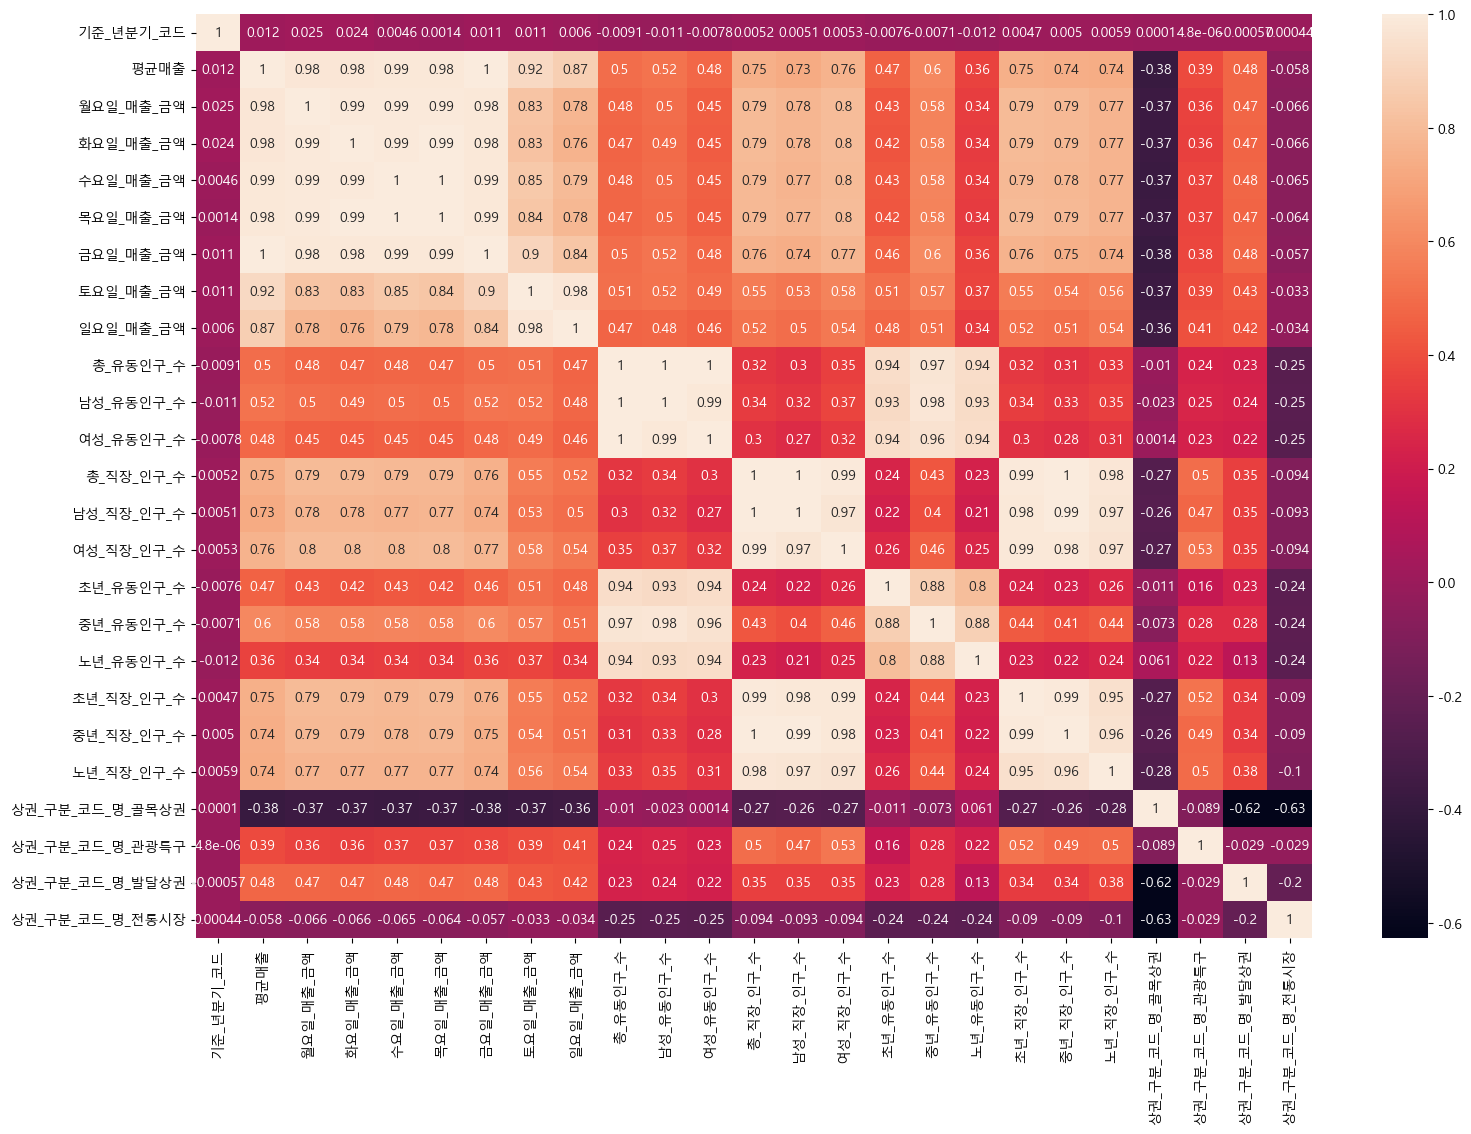

In [40]:
plt.figure(figsize=(18, 12))
sns.heatmap(restaurant_correlation_matrix, annot=True)
plt.show()

In [41]:
restaurant_filtered_data.to_csv("../data/서울시_요식업_데이터.csv", encoding="cp949", index=False)

## 시각화 및 분석

In [42]:
seoul_df=pd.read_csv("../data/서울시_요식업_데이터.csv", encoding="cp949")
seoul_df

,기준_년분기_코드,상권_코드_명,서비스업종,평균매출,월요일_매출_금액,화요일_매출_금액,수요일_매출_금액,목요일_매출_금액,금요일_매출_금액,토요일_매출_금액,...,초년_유동인구_수,중년_유동인구_수,노년_유동인구_수,초년_직장_인구_수,중년_직장_인구_수,노년_직장_인구_수,상권_구분_코드_명_골목상권,상권_구분_코드_명_관광특구,상권_구분_코드_명_발달상권,상권_구분_코드_명_전통시장
0,20241,4.19민주묘지역 2번,요식업,5.791738e+08,7.595857e+07,6.386816e+07,8.260543e+07,5.811491e+07,8.225960e+07,1.158725e+08,...,309395.0,285963.0,425816.0,4.0,29.0,131.0,True,False,False,False
1,20242,4.19민주묘지역 2번,요식업,6.476178e+08,6.640149e+07,8.469500e+07,9.544292e+07,6.870253e+07,8.831480e+07,1.151779e+08,...,345370.0,281203.0,439184.0,4.0,29.0,131.0,True,False,False,False
2,20243,4.19민주묘지역 2번,요식업,5.785566e+08,5.557269e+07,7.413718e+07,7.940513e+07,5.871730e+07,7.947643e+07,1.047350e+08,...,284759.0,274230.0,422935.0,4.0,29.0,131.0,True,False,False,False
3,20244,4.19민주묘지역 2번,요식업,4.837946e+08,4.671709e+07,7.365159e+07,7.410768e+07,4.735737e+07,5.921922e+07,9.416708e+07,...,295155.0,261708.0,394544.0,5.0,42.0,192.0,True,False,False,False
4,20241,63빌딩,요식업,1.214889e+09,1.718305e+08,1.981513e+08,2.013047e+08,2.035040e+08,1.777674e+08,1.511339e+08,...,14542.0,24672.0,22923.0,1492.0,4934.0,1590.0,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5910,20244,흑리단길,요식업,4.471095e+08,5.694142e+07,7.229898e+07,6.317090e+07,5.951992e+07,7.513741e+07,8.128673e+07,...,52809.0,49233.0,63713.0,0.0,13.0,9.0,True,False,False,False
5911,20241,흑석시장,요식업,2.768305e+08,4.012902e+07,4.407540e+07,4.829691e+07,4.976233e+07,4.734645e+07,3.404217e+07,...,28248.0,25419.0,31037.0,0.0,1.0,0.0,False,False,False,True
5912,20242,흑석시장,요식업,4.008547e+08,7.667108e+07,6.577886e+07,6.997424e+07,7.328599e+07,6.259257e+07,4.066760e+07,...,29745.0,25491.0,30606.0,0.0,1.0,0.0,False,False,False,True
5913,20243,흑석시장,요식업,3.245011e+08,5.180170e+07,4.784433e+07,5.132454e+07,6.179132e+07,5.683618e+07,4.035472e+07,...,23998.0,22179.0,26710.0,0.0,1.0,0.0,False,False,False,True


In [43]:
seoul_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5915 entries, 0 to 5914
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   기준_년분기_코드        5915 non-null   int64  
 1   상권_코드_명          5915 non-null   object 
 2   서비스업종            5915 non-null   object 
 3   평균매출             5915 non-null   float64
 4   월요일_매출_금액        5915 non-null   float64
 5   화요일_매출_금액        5915 non-null   float64
 6   수요일_매출_금액        5915 non-null   float64
 7   목요일_매출_금액        5915 non-null   float64
 8   금요일_매출_금액        5915 non-null   float64
 9   토요일_매출_금액        5915 non-null   float64
 10  일요일_매출_금액        5915 non-null   float64
 11  총_유동인구_수         5915 non-null   float64
 12  남성_유동인구_수        5915 non-null   float64
 13  여성_유동인구_수        5915 non-null   float64
 14  총_직장_인구_수        5915 non-null   float64
 15  남성_직장_인구_수       5915 non-null   float64
 16  여성_직장_인구_수       5915 non-null   float64
 17  초년_유동인구_수     

In [44]:
seoul_df.describe().T

,count,mean,std,min,25%,50%,75%,max
기준_년분기_코드,5915.0,2.024250e+04,1.118507e+00,20241.0,2.024100e+04,2.024200e+04,2.024400e+04,2.024400e+04
평균매출,5915.0,6.709910e+08,1.154353e+09,142495.0,1.727753e+08,3.506407e+08,6.727847e+08,1.964679e+10
월요일_매출_금액,5915.0,8.682840e+07,1.583718e+08,0.0,2.086961e+07,4.331082e+07,8.845654e+07,2.994927e+09
화요일_매출_금액,5915.0,9.572184e+07,1.765173e+08,0.0,2.362564e+07,4.789077e+07,9.489931e+07,3.278988e+09
수요일_매출_금액,5915.0,9.674554e+07,1.757890e+08,0.0,2.379729e+07,4.836944e+07,9.559192e+07,3.070113e+09
목요일_매출_금액,5915.0,9.924329e+07,1.851290e+08,0.0,2.406777e+07,4.884426e+07,9.771408e+07,3.194430e+09
금요일_매출_금액,5915.0,1.093292e+08,1.950043e+08,0.0,2.727346e+07,5.525976e+07,1.082157e+08,3.455566e+09
토요일_매출_금액,5915.0,1.054993e+08,1.783195e+08,0.0,2.577434e+07,5.503145e+07,1.121020e+08,2.285705e+09
일요일_매출_금액,5915.0,7.762345e+07,1.288229e+08,0.0,1.645034e+07,4.077456e+07,8.632923e+07,1.541997e+09
총_유동인구_수,5915.0,8.868644e+05,9.034888e+05,4.0,2.758435e+05,6.320570e+05,1.228710e+06,8.484242e+06


In [45]:
seoul_df_corr=seoul_df.select_dtypes(["float64", "int64", "bool"]).corr()
seoul_df_corr_sort=seoul_df_corr["평균매출"].abs().sort_values(ascending=False)
seoul_df_corr_sort

평균매출               1.000000
금요일_매출_금액          0.995370
수요일_매출_금액          0.986344
목요일_매출_금액          0.983648
월요일_매출_금액          0.980316
화요일_매출_금액          0.978897
토요일_매출_금액          0.921002
일요일_매출_금액          0.873152
여성_직장_인구_수         0.761112
초년_직장_인구_수         0.748436
총_직장_인구_수          0.747404
중년_직장_인구_수         0.740826
노년_직장_인구_수         0.735186
남성_직장_인구_수         0.730131
중년_유동인구_수          0.595130
남성_유동인구_수          0.522115
총_유동인구_수           0.501838
여성_유동인구_수          0.479396
상권_구분_코드_명_발달상권    0.478829
초년_유동인구_수          0.465821
상권_구분_코드_명_관광특구    0.388701
상권_구분_코드_명_골목상권    0.384099
노년_유동인구_수          0.359438
상권_구분_코드_명_전통시장    0.057885
기준_년분기_코드          0.012227
Name: 평균매출, dtype: float64

In [46]:
idx=seoul_df_corr_sort[0:23].index
idx

Index(['평균매출', '금요일_매출_금액', '수요일_매출_금액', '목요일_매출_금액', '월요일_매출_금액', '화요일_매출_금액',
       '토요일_매출_금액', '일요일_매출_금액', '여성_직장_인구_수', '초년_직장_인구_수', '총_직장_인구_수',
       '중년_직장_인구_수', '노년_직장_인구_수', '남성_직장_인구_수', '중년_유동인구_수', '남성_유동인구_수',
       '총_유동인구_수', '여성_유동인구_수', '상권_구분_코드_명_발달상권', '초년_유동인구_수',
       '상권_구분_코드_명_관광특구', '상권_구분_코드_명_골목상권', '노년_유동인구_수'],
      dtype='object')

In [47]:
seoul=seoul_df[idx]
seoul.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5915 entries, 0 to 5914
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   평균매출             5915 non-null   float64
 1   금요일_매출_금액        5915 non-null   float64
 2   수요일_매출_금액        5915 non-null   float64
 3   목요일_매출_금액        5915 non-null   float64
 4   월요일_매출_금액        5915 non-null   float64
 5   화요일_매출_금액        5915 non-null   float64
 6   토요일_매출_금액        5915 non-null   float64
 7   일요일_매출_금액        5915 non-null   float64
 8   여성_직장_인구_수       5915 non-null   float64
 9   초년_직장_인구_수       5915 non-null   float64
 10  총_직장_인구_수        5915 non-null   float64
 11  중년_직장_인구_수       5915 non-null   float64
 12  노년_직장_인구_수       5915 non-null   float64
 13  남성_직장_인구_수       5915 non-null   float64
 14  중년_유동인구_수        5915 non-null   float64
 15  남성_유동인구_수        5915 non-null   float64
 16  총_유동인구_수         5915 non-null   float64
 17  여성_유동인구_수     

In [48]:
seoul.describe().T.astype(int)

,count,mean,std,min,25%,50%,75%,max
평균매출,5915,670991032,1154352787,142495,172775287,350640732,672784697,19646791038
금요일_매출_금액,5915,109329195,195004270,0,27273461,55259763,108215678,3455565569
수요일_매출_금액,5915,96745539,175789045,0,23797286,48369442,95591924,3070112917
목요일_매출_금액,5915,99243289,185128997,0,24067772,48844265,97714083,3194430071
월요일_매출_금액,5915,86828404,158371769,0,20869613,43310815,88456539,2994927285
화요일_매출_금액,5915,95721835,176517332,0,23625644,47890773,94899309,3278987896
토요일_매출_금액,5915,105499313,178319459,0,25774339,55031449,112101980,2285705082
일요일_매출_금액,5915,77623451,128822895,0,16450341,40774557,86329233,1541997171
여성_직장_인구_수,5915,1168,4347,0,80,199,567,91159
초년_직장_인구_수,5915,550,2233,0,21,63,218,43666


In [49]:
seoul.columns

Index(['평균매출', '금요일_매출_금액', '수요일_매출_금액', '목요일_매출_금액', '월요일_매출_금액', '화요일_매출_금액',
       '토요일_매출_금액', '일요일_매출_금액', '여성_직장_인구_수', '초년_직장_인구_수', '총_직장_인구_수',
       '중년_직장_인구_수', '노년_직장_인구_수', '남성_직장_인구_수', '중년_유동인구_수', '남성_유동인구_수',
       '총_유동인구_수', '여성_유동인구_수', '상권_구분_코드_명_발달상권', '초년_유동인구_수',
       '상권_구분_코드_명_관광특구', '상권_구분_코드_명_골목상권', '노년_유동인구_수'],
      dtype='object')

In [50]:
col1 = ["월요일_매출_금액", "화요일_매출_금액", "수요일_매출_금액", "목요일_매출_금액",
        "금요일_매출_금액", "토요일_매출_금액", "일요일_매출_금액", "총_유동인구_수", "남성_유동인구_수",
        "여성_유동인구_수", "총_직장_인구_수", "남성_직장_인구_수", "여성_직장_인구_수", "초년_유동인구_수",
        "중년_유동인구_수", "노년_유동인구_수", "초년_직장_인구_수", "중년_직장_인구_수", "노년_직장_인구_수",
        "상권_구분_코드_명_골목상권", "상권_구분_코드_명_발달상권", "상권_구분_코드_명_관광특구"]

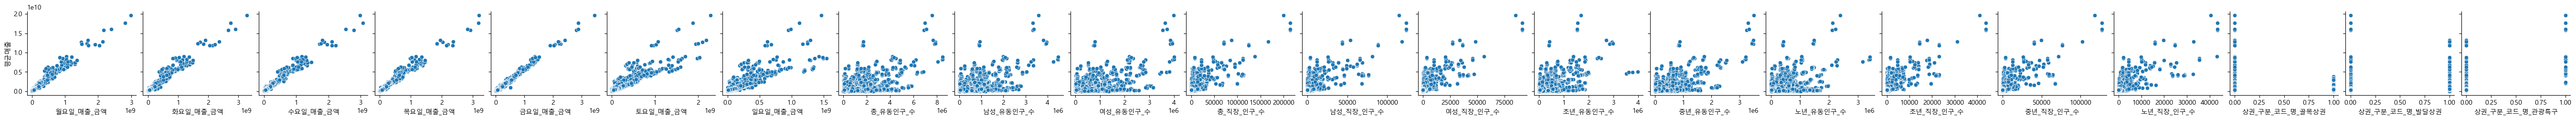

In [51]:
sns.pairplot(data=seoul, x_vars=col1, y_vars="평균매출")

In [52]:
col2 = ["총_유동인구_수", "남성_유동인구_수", "여성_유동인구_수",
        "총_직장_인구_수", "남성_직장_인구_수", "여성_직장_인구_수", "초년_유동인구_수",
        "중년_유동인구_수", "노년_유동인구_수", "초년_직장_인구_수", "중년_직장_인구_수", "노년_직장_인구_수",
        "상권_구분_코드_명_골목상권", "상권_구분_코드_명_발달상권", "상권_구분_코드_명_관광특구"]

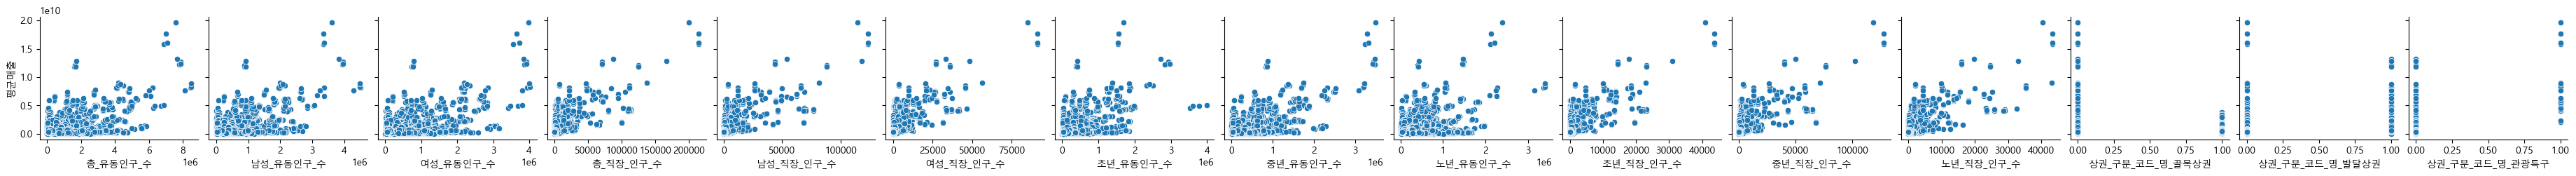

In [53]:
sns.pairplot(data=seoul, x_vars=col2, y_vars="평균매출")

In [54]:
#col3 = ["총_유동인구_수", "총_직장_인구_수", "상권_구분_코드_명_골목상권", "상권_구분_코드_명_발달상권", "상권_구분_코드_명_관광특구"]


## 모델 학습 및 평가

In [55]:
X = seoul[col2]
Y = seoul["평균매출"]
print(X.shape, type(X))
print(Y.shape, type(Y))

(5915, 15) <class 'pandas.core.frame.DataFrame'>
(5915,) <class 'pandas.core.series.Series'>


### LinearRegg

> 훈련, 테스트 데이터 나누기

In [56]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((4732, 15), (4732,), (1183, 15), (1183,))

> 스케일링

In [57]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

> 모델 학습

In [58]:
lr=LinearRegression()
lr.fit(X_train_scaled, Y_train)

LinearRegression()

> 성능 평가

In [59]:
print("학습: ", lr.score(X_train_scaled, Y_train))
print("일반화: ", lr.score(X_test_scaled, Y_test))

학습:  0.7457932658956388
일반화:  0.647190812777837


> 평가지표  

In [60]:
Y_train_pred=lr.predict(X_train)
Y_test_pred=lr.predict(X_test)

d:\anaconda\envs\thirdENV\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
d:\anaconda\envs\thirdENV\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [61]:
def regg_eval(model):
    Y_train_pred=lr.predict(X_train)
    Y_test_pred=lr.predict(X_test)
    
    print("학습 R2:", r2_score(Y_train, Y_train_pred))
    print("일반화 R2:", r2_score(Y_test, Y_test_pred), "\n")
    
    print("학습 MSE:", mean_squared_error(Y_train, Y_train_pred))
    print("일반화 MSE:", mean_squared_error(Y_test, Y_test_pred), "\n")
    
    print("학습 RMSE:", root_mean_squared_error(Y_train, Y_train_pred))
    print("일반화 RMSE:", root_mean_squared_error(Y_test, Y_test_pred), "\n")
    
    print("학습 MAE:", mean_absolute_error(Y_train, Y_train_pred))
    print("일반화 MAE:", mean_absolute_error(Y_test, Y_test_pred))

In [62]:
regg_eval(lr)

학습 R2: -1.132513477250739e+17
일반화 R2: -1.1555550958683698e+17 

학습 MSE: 1.5692508930359167e+35
일반화 MSE: 1.2930427201065519e+35 

학습 RMSE: 3.96137715073422e+17
일반화 RMSE: 3.5958903210561805e+17 

학습 MAE: 2.7600825877695126e+17
일반화 MAE: 2.581834333947578e+17


d:\anaconda\envs\thirdENV\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
d:\anaconda\envs\thirdENV\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


선형회귀로 하니 잘 잡아내지 못했다.  

### PolynomialRegg

> 훈련, 테스트 데이터 나누기

In [100]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

> 다항식 변환

In [101]:
poly = PolynomialFeatures(include_bias=False)
poly.fit(X_train)

PolynomialFeatures(include_bias=False)

이렇게 fit을 통해 학습을 시켜서 다항식 차수에 따라 변환할 특성들을 결정했고,  
transform을 통해 데이터를 실제로 다항식 특성을 변환하면,  

In [102]:
X_train_poly = poly.transform(X_train)
print(X_train_poly.shape)
print(X_train_poly[:3])
print(poly.get_feature_names_out())

(4732, 135)
[[2.30021000e+05 1.01260000e+05 1.28761000e+05 3.20000000e+02
  2.22000000e+02 9.80000000e+01 5.95850000e+04 1.06623000e+05
  6.38130000e+04 4.90000000e+01 1.74000000e+02 9.70000000e+01
  1.00000000e+00 0.00000000e+00 0.00000000e+00 5.29096604e+10
  2.32919265e+10 2.96177340e+10 7.36067200e+07 5.10646620e+07
  2.25420580e+07 1.37058013e+10 2.45255291e+10 1.46783301e+10
  1.12710290e+07 4.00236540e+07 2.23120370e+07 2.30021000e+05
  0.00000000e+00 0.00000000e+00 1.02535876e+10 1.30383389e+10
  3.24032000e+07 2.24797200e+07 9.92348000e+06 6.03357710e+09
  1.07966450e+10 6.46170438e+09 4.96174000e+06 1.76192400e+07
  9.82222000e+06 1.01260000e+05 0.00000000e+00 0.00000000e+00
  1.65793951e+10 4.12035200e+07 2.85849420e+07 1.26185780e+07
  7.67222418e+09 1.37288841e+10 8.21662569e+09 6.30928900e+06
  2.24044140e+07 1.24898170e+07 1.28761000e+05 0.00000000e+00
  0.00000000e+00 1.02400000e+05 7.10400000e+04 3.13600000e+04
  1.90672000e+07 3.41193600e+07 2.04201600e+07 1.56800000e

In [103]:
X_test_poly = poly.transform(X_test)
X_test_poly.shape

(1183, 135)

> 스케일링

In [104]:
scaler=StandardScaler()
scaler.fit(X_train_poly)

X_train_scaled=scaler.transform(X_train_poly)
X_test_scaled=scaler.transform(X_test_poly)

> 모델 학습

In [105]:
lr=LinearRegression()
lr.fit(X_train_scaled, Y_train)

LinearRegression()

> 성능 평가

In [106]:
print("학습: ", lr.score(X_train_scaled, Y_train))
print("일반화: ", lr.score(X_test_scaled, Y_test))

학습:  0.8410105833209497
일반화:  -0.24030468363527224


Overfitting의 결과가 나왔다.  
default인 2차로 진행했는데 학습은 많이 올랐지만, 테스트는 현저히 떨어진다.  

그렇다면 이런 과적합을 방지하기 위해 규제를 걸어서 패널티를 추가하여 cost값을 벌려보자.  

<!--이렇게 되면 테스트 데이터의 예측율이 완전히 떨어졌다.  

default인 2차로 진행했는데 학습은 많이 올랐지만, 테스트는 현저히 떨어진다.  
따라서 차수를 조절해보자.  

선형회귀의 목표는 결국 Y값이라는 실제값과 Y^ 이라는 예측값의 오차를 줄이는 것이 목표이기 때문에,  
최대한 cost가 0에 가깝게 하는 것이 목표다.  

그렇게 0에 까까운 w와 b를 구해서 데이터를 뿌려서 예측하는 거였는데,  
지금 보면 cost가-->

### Ridge, Lasso, ElasticNet

In [107]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

ridge = Ridge()  # default: 1.0
ridge.fit(X_train_scaled, Y_train)
print("Ridge 학습: ", ridge.score(X_train_scaled, Y_train))
print("Ridge 일반화: ", ridge.score(X_test_scaled, Y_test))


Ridge 학습:  0.8261058648032511
Ridge 일반화:  0.7529241151553989


In [108]:
lasso=Lasso(tol=0.1)
lasso.fit(X_train_scaled, Y_train)
print("Lasso 학습: ", lasso.score(X_train_scaled, Y_train))
print("Lasso 일반화: ", lasso.score(X_test_scaled, Y_test))

Lasso 학습:  0.8000116718088589
Lasso 일반화:  0.7004695799549951


In [109]:
elastic_net=ElasticNet(tol=1)  
elastic_net.fit(X_train_scaled, Y_train)
print("ElasticNet 학습: ", elastic_net.score(X_train_scaled, Y_train))
print("ElasticNet 일반화: ", elastic_net.score(X_test_scaled, Y_test))

ElasticNet 학습:  0.7873619129941667
ElasticNet 일반화:  0.6849842902765872


tol: 반복 멈추는 기준  
작은 tol(0.0001)은 더 정확한 결과 -> 오래걸림  
큰 tol(0.01)은 더 빠르지만 덜 정확   

그런데 Lasso와 ElasticNet은 각각 0.1, 1로 설정해줘야 에러 발생 안함  
에러 내용: 모델이 제대로 학습되지 않았다.  


그리고 이를 보면 Ridge의 경우가 가장 잘나왔다.  
일반화 성능이 개선되면서 과적합이 조금 완화됐다.  

훈련과 학습이 각각,  
릿지: 0.8261 | 0.7529  
라쏘: 0.8000 | 0.7005  
엘라: 0.7873 | 0.6849  

라쏘와 엘라스틱넷은 학습 성능이 약간 낮고, 일반화 성능도 떨어진다.  
릿지가 과적합을 잘 조절한 모델이라 가장 최선의 선택이다.  

### 모델 최적화  
> 교차 검증

이제 교차 검증을 해보자.  
먼저 5-fold의 경우다.  

In [110]:
val_data = cross_validate(ridge, X_train_scaled, Y_train, cv=5)
val_data

{'fit_time': array([0.01196837, 0.0109694 , 0.01097107, 0.01327133, 0.01369166]),
 'score_time': array([0.0010004 , 0.00399065, 0.00199366, 0.0029912 , 0.0029974 ]),
 'test_score': array([0.82665405, 0.76066017, 0.84569194, 0.7816931 , 0.80477716])}

교차 검증 점수 값은 `'test_score': array([0.82665405, 0.76066017, 0.84569194, 0.7816931 , 0.80477716])` 이다.  
즉 test_score는 데이터에 대해 모델의 성능을 평가한 정확도이며,  
fit_time은 모델 학습에 소요된 시간,  
score_time은 테스트 데이터에 대한 점수를 게산하는데 걸리는 시간이다.  

In [111]:
print("학습: ", ridge.score(X_train_scaled, Y_train))
print("검증: ", val_data["test_score"].mean())  # 교차 검증 성능의 평균  
print("일반화: ", ridge.score(X_test_scaled, Y_test))

학습:  0.8261058648032511
검증:  0.803895284515111
일반화:  0.7529241151553989


In [112]:
scores = cross_validate(ridge, X_train_scaled, Y_train, cv=5, n_jobs=-1, return_train_score=True)

print("각 fold 훈련 정확도: ", scores["train_score"])
print("훈련 평균: ", scores["train_score"].mean(), "\n")

print("각 fold 검증 정확도: ", scores["test_score"])
print("검증 평균: ", scores["test_score"].mean())

각 fold 훈련 정확도:  [0.8194882  0.84080563 0.81788801 0.8317867  0.82539445]
훈련 평균:  0.8270725975590187 

각 fold 검증 정확도:  [0.82665405 0.76066017 0.84569194 0.7816931  0.80477716]
검증 평균:  0.8038952845151146


이번에는 7-fold 교차검증

In [113]:
scores = cross_validate(ridge, X_train_scaled, Y_train, cv=7, n_jobs=-1, return_train_score=True)

print("각 fold 훈련 정확도: ", scores["train_score"])
print("훈련 평균: ", scores["train_score"].mean(), "\n")

print("각 fold 검증 정확도: ", scores["test_score"])
print("검증 평균: ", scores["test_score"].mean())

각 fold 훈련 정확도:  [0.82208108 0.82672253 0.83614033 0.81724639 0.82754937 0.82675655
 0.83003338]
훈련 평균:  0.8266470915363902 

각 fold 검증 정확도:  [0.83497652 0.81533046 0.75615637 0.85501191 0.80581658 0.80922604
 0.76587129]
검증 평균:  0.8060555961100372


조금 늘어나긴 하지만 그만큼 훈련과 검증을 더 많이 수행해야 하니까 그냥 5-fold를 사용한다.  
이제 각각 찍어보면,  

In [114]:
print("[ Ridge ] ------------------------------------------------------")
ridge_scores = cross_validate(ridge, X_train_scaled, Y_train, cv=5, n_jobs=-1, return_train_score=True)
print("Ridge 각 fold 훈련 정확도: ", ridge_scores["train_score"])
print("Ridge 훈련 평균: ", ridge_scores["train_score"].mean(), "\n")
print("Ridge 각 fold 검증 정확도: ", ridge_scores["test_score"])
print("Ridge 검증 평균: ", ridge_scores["test_score"].mean(), "\n")

print("[ Lasso ] ------------------------------------------------------")
lasso_scores = cross_validate(lasso, X_train_scaled, Y_train, cv=5, n_jobs=-1, return_train_score=True)
print("Lasso 각 fold 훈련 정확도: ", lasso_scores["train_score"])
print("Lasso 훈련 평균: ", lasso_scores["train_score"].mean(), "\n")
print("Lasso 각 fold 검증 정확도: ", lasso_scores["test_score"])
print("Lasso 검증 평균: ", lasso_scores["test_score"].mean(), "\n")

print("[ ElasticNet ] ------------------------------------------------------")
elastic_net_scores = cross_validate(elastic_net, X_train_scaled, Y_train, cv=5, n_jobs=-1, return_train_score=True)
print("ElasticNet 각 fold 훈련 정확도: ", elastic_net_scores["train_score"])
print("ElasticNet 훈련 평균: ", elastic_net_scores["train_score"].mean(), "\n")
print("ElasticNet 각 fold 검증 정확도: ", elastic_net_scores["test_score"])
print("ElasticNet 검증 평균: ", elastic_net_scores["test_score"].mean(), "\n")

[ Ridge ] ------------------------------------------------------
Ridge 각 fold 훈련 정확도:  [0.8194882  0.84080563 0.81788801 0.8317867  0.82539445]
Ridge 훈련 평균:  0.8270725975590187 

Ridge 각 fold 검증 정확도:  [0.82665405 0.76066017 0.84569194 0.7816931  0.80477716]
Ridge 검증 평균:  0.8038952845151146 

[ Lasso ] ------------------------------------------------------
Lasso 각 fold 훈련 정확도:  [0.80030321 0.8020417  0.80005714 0.80011386 0.80008483]
Lasso 훈련 평균:  0.8005201484088204 

Lasso 각 fold 검증 정확도:  [0.7914236  0.74104088 0.82063712 0.75015678 0.8223968 ]
Lasso 검증 평균:  0.7851310368718387 

[ ElasticNet ] ------------------------------------------------------
ElasticNet 각 fold 훈련 정확도:  [0.78688653 0.79821504 0.78103014 0.79371597 0.78039214]
ElasticNet 훈련 평균:  0.7880479613877911 

ElasticNet 각 fold 검증 정확도:  [0.78622016 0.74127386 0.81258941 0.7407302  0.80788351]
ElasticNet 검증 평균:  0.777739426177642 



이렇게 검증 성능의 평균은  
릿지: 0.8093  
라쏘: 0.7851  
엘라: 0.7777  

으로 릿지가 가장 높은 검증 성능을 가져 가장 안정적이고  
라쏘와 엘라스틱넷은 검증 점수가 낮아서 릿지보다 성능이 떨어진다.  

또한 각각 과적합은 아니고 차이가 적다.  
따라서 릿지가 가장 안정적이다.  

성능 개선을 위해 하이퍼파라미터 튜닝을 진행.  

> 하이파라미터 튜닝

In [134]:
from sklearn.model_selection import GridSearchCV

ridge = Ridge()

params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
gs = GridSearchCV(ridge, params, cv=5, n_jobs=-1)
gs.fit(X_train_scaled, Y_train)
print("최적 alpha 값: ", gs.best_params_)
print("최적 검증 점수: ", gs.best_score_)

최적 alpha 값:  {'alpha': 0.01}
최적 검증 점수:  0.8107846081573866


그리고 이를 이용해 최적의 값으로 학습하면  

In [135]:
best_ridge = Ridge(alpha=gs.best_params_["alpha"])
best_ridge.fit(X_train_scaled, Y_train)

print("학습 점수:", best_ridge.score(X_train_scaled, Y_train))
print("일반화 점수:", best_ridge.score(X_test_scaled, Y_test))

학습 점수: 0.8363066644862615
일반화 점수: 0.7696550404172239


학습점수 (0.8261 -> 0.8363)  
일반화 (0.7529 -> 0.7697)  

> 평가지표

In [136]:
Y_train_pred = best_ridge.predict(X_train_scaled)
Y_test_pred = best_ridge.predict(X_test_scaled)

In [137]:
print("학습 데이터 예측 값: ", Y_train_pred[:10])
print("테스트 데이터 예측 값: ", Y_test_pred[:10])

학습 데이터 예측 값:  [3.73818639e+08 4.52586036e+09 4.12591512e+08 3.63332679e+08
 3.31445715e+08 7.90507602e+08 2.14159224e+09 6.16564354e+08
 2.00770834e+09 2.99574000e+08]
테스트 데이터 예측 값:  [3.18792638e+08 2.43864917e+08 3.81390330e+08 3.54748781e+08
 3.94303177e+08 3.15859192e+08 3.77904085e+08 2.72003629e+08
 6.79817678e+08 9.40456904e+08]


In [138]:
print("학습 R2:", r2_score(Y_train, Y_train_pred))
print("일반화 R2:", r2_score(Y_test, Y_test_pred), "\n")

print("학습 MSE:", mean_squared_error(Y_train, Y_train_pred))
print("일반화 MSE:", mean_squared_error(Y_test, Y_test_pred), "\n")

print("학습 RMSE:", root_mean_squared_error(Y_train, Y_train_pred))
print("일반화 RMSE:", root_mean_squared_error(Y_test, Y_test_pred), "\n")

print("학습 MAE:", mean_absolute_error(Y_train, Y_train_pred))
print("일반화 MAE:", mean_absolute_error(Y_test, Y_test_pred))

학습 R2: 0.8363066644862615
일반화 R2: 0.7696550404172239 

학습 MSE: 2.268192989301527e+17
일반화 MSE: 2.5775133887313533e+17 

학습 RMSE: 476255497.53273475
일반화 RMSE: 507692169.4030107 

학습 MAE: 298303387.3456144
일반화 MAE: 307898267.42187864


값이 너무 큼..

In [139]:
Y_train_log = np.log1p(Y_train)  # 로그 변환
Y_test_log = np.log1p(Y_test)

# 모델 학습 시 변환된 값을 사용
best_ridge.fit(X_train_scaled, Y_train_log)
Y_train_pred_log = best_ridge.predict(X_train_scaled)
Y_test_pred_log = best_ridge.predict(X_test_scaled)

# 로그 변환된 예측값을 역변환하여 원래 스케일로 되돌리기
Y_train_pred = np.expm1(Y_train_pred_log)
Y_test_pred = np.expm1(Y_test_pred_log)

In [140]:
print("학습 R2:", r2_score(Y_train, Y_train_pred))
print("일반화 R2:", r2_score(Y_test, Y_test_pred), "\n")

print("학습 MSE:", mean_squared_error(Y_train, Y_train_pred))
print("일반화 MSE:", mean_squared_error(Y_test, Y_test_pred), "\n")

print("학습 RMSE:", root_mean_squared_error(Y_train, Y_train_pred))
print("일반화 RMSE:", root_mean_squared_error(Y_test, Y_test_pred), "\n")

print("학습 MAE:", mean_absolute_error(Y_train, Y_train_pred))
print("일반화 MAE:", mean_absolute_error(Y_test, Y_test_pred))

학습 R2: 0.7660846501856791
일반화 R2: 0.6881984074846805 

학습 MSE: 3.2412141573981645e+17
일반화 MSE: 3.488996593594609e+17 

학습 RMSE: 569316621.6964128
일반화 RMSE: 590677288.6775494 

학습 MAE: 309568844.2915498
일반화 MAE: 322330850.8201632


로그 적용해도 너무 큼

### KNR

In [141]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [142]:
scaler=StandardScaler()
scaler.fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [143]:
kn=KNeighborsRegressor()
kn.fit(X_train_scaled, Y_train)
print("학습: ", kn.score(X_train_scaled, Y_train))
print("일반화: ", kn.score(X_test_scaled, Y_test))

학습:  0.9105171618325785
일반화:  0.7942740622404924


선형회귀보다 KNR의 값이 더 잘나왔지만 여전히 과대적합이다.  
지역구분으로 묶여있는 것들이 있기 때문에 더 높게 나온 거 같다.  

In [144]:
params={"n_neighbors":[3,5,7,9,11]}
gs=GridSearchCV(KNeighborsRegressor(), params, cv=5, n_jobs=-1)

In [145]:
gs.fit(X_train_scaled, Y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 9, 11]})

In [146]:
gs.best_params_

{'n_neighbors': 3}

In [147]:
gs.best_score_

np.float64(0.851943091844632)

In [148]:
knn_best=gs.best_estimator_
knn_best.score(X_test_scaled, Y_test)

0.8928012727122335

In [149]:
gs.predict(X_test_scaled)

array([3.81473077e+07, 2.28400115e+08, 2.44184204e+08, ...,
       7.99361131e+08, 1.11866281e+08, 5.87587453e+08], shape=(1183,))

### DecisionTreeReg

In [150]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [151]:
dt=DecisionTreeRegressor(max_depth=5, random_state=42)
dt.fit(X_train, Y_train)

DecisionTreeRegressor(max_depth=5, random_state=42)

In [152]:
print("학습: ", dt.score(X_train, Y_train))
print("일반화: ", dt.score(X_test, Y_test))

학습:  0.8276636255999974
일반화:  0.7173026481597714


In [153]:
dt.feature_importances_

array([0.06807905, 0.00169695, 0.        , 0.00607765, 0.05084485,
       0.49242575, 0.00608311, 0.21155149, 0.00801195, 0.        ,
       0.        , 0.02032994, 0.00862235, 0.1262769 , 0.        ])

In [154]:
X_col=X.columns
X_col

Index(['총_유동인구_수', '남성_유동인구_수', '여성_유동인구_수', '총_직장_인구_수', '남성_직장_인구_수',
       '여성_직장_인구_수', '초년_유동인구_수', '중년_유동인구_수', '노년_유동인구_수', '초년_직장_인구_수',
       '중년_직장_인구_수', '노년_직장_인구_수', '상권_구분_코드_명_골목상권', '상권_구분_코드_명_발달상권',
       '상권_구분_코드_명_관광특구'],
      dtype='object')

여성_직장_인구_수가 들어갈 것이다.  

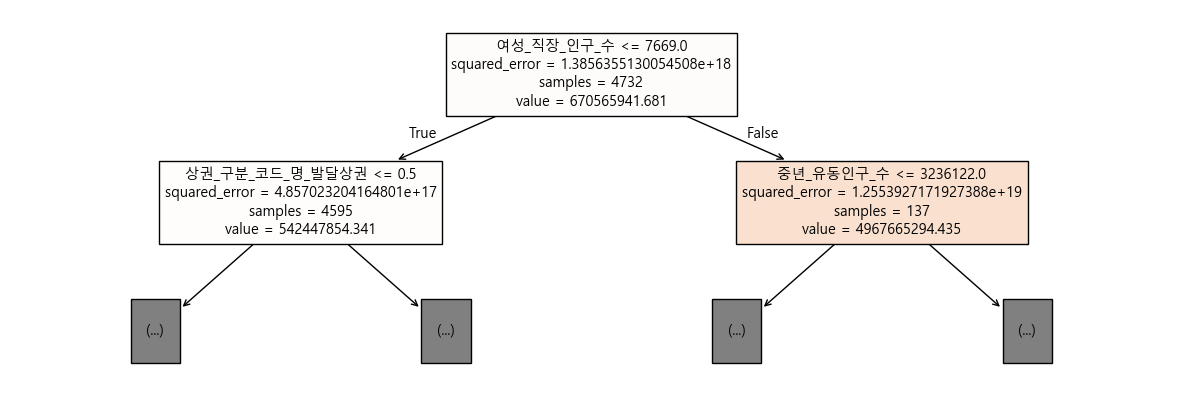

In [155]:
plt.figure(figsize=(15,5))
plot_tree(dt, max_depth=1, filled=True, feature_names=X_col)
plt.show()

In [156]:
DecisionTreeRegressor().get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': None,
 'splitter': 'best'}

In [157]:
params={
    "max_depth": np.arange(5, 20),
    "min_impurity_decrease": np.arange(0.0001, 0.0006, 0.0001),
    "min_samples_split": np.arange(2, 100, 2)
}

gs = GridSearchCV(DecisionTreeRegressor(random_state=42), params, n_jobs=-1, cv=5)
gs.fit(X_train, Y_train)

gs.best_params_

{'max_depth': np.int64(19),
 'min_impurity_decrease': np.float64(0.0001),
 'min_samples_split': np.int64(2)}

In [158]:
gs.best_score_

np.float64(0.8457730124024765)

In [159]:
gs_best=gs.best_estimator_
gs_best.score(X_test, Y_test)

0.838623065537416

In [160]:
gs.predict(X_test)

array([4.12681445e+08, 2.39449867e+08, 2.21824738e+08, ...,
       7.80632109e+08, 1.53964831e+08, 5.29357522e+08], shape=(1183,))

In [161]:
y_pred = gs_best.predict(X_test)

mse = mean_squared_error(Y_test, y_pred)
mae = mean_absolute_error(Y_test, y_pred)
r2 = gs_best.score(X_test, Y_test)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R2: {r2}")

MSE: 1.8057751728674464e+17
MAE: 199309746.09438202
R2: 0.838623065537416


MSE: 너무 큰 값으로 모델의 예측값과 실제 값 사이에 큰 차이가 있다.  
MAE: 예측값과 실제값 사이의 절대값 평균인데, 이 또한 예측값이 실제값에서 상당히 벗어난 것이다.  
R2은 0과 1사이의 값으로 괜찮게 잘 나왔다.  

그렇다면 스케일을 조절해서 해보자.  

In [162]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

Y_train_log = np.log1p(Y_train)
Y_test_log = np.log1p(Y_test)

gs.fit(X_train, Y_train_log)

y_pred_log = gs.best_estimator_.predict(X_test)

y_pred = np.expm1(y_pred_log)

mse = mean_squared_error(Y_test, y_pred)
mae = mean_absolute_error(Y_test, y_pred)
r2 = gs.best_estimator_.score(X_test, Y_test)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

MSE: 2.1034653576599907e+17
MAE: 235998167.0394024
R²: -0.4043984696318699


In [163]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

gs.fit(X_train_scaled, Y_train)
y_pred = gs.best_estimator_.predict(X_test_scaled)

mse = mean_squared_error(Y_test, y_pred)
mae = mean_absolute_error(Y_test, y_pred)
r2 = gs.best_estimator_.score(X_test_scaled, Y_test)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R2: {r2}")

MSE: 1.8059164347452323e+17
MAE: 199335887.55845642
R2: 0.8386104413696148


### RandomForestReg

In [164]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [165]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, Y_train)

y_pred_rf = rf.predict(X_test)

mse_rf = mean_squared_error(Y_test, y_pred_rf)
mae_rf = mean_absolute_error(Y_test, y_pred_rf)
r2_rf = rf.score(X_test, Y_test)

print(f"Random Forest MSE: {mse_rf}")
print(f"Random Forest MAE: {mae_rf}")
print(f"Random Forest R²: {r2_rf}")

Random Forest MSE: 9.136498646432008e+16
Random Forest MAE: 162906690.40964067
Random Forest R²: 0.9183497389134292


In [166]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_scaled, Y_train)

print("학습 점수 (Train score): ", rf.score(X_train_scaled, Y_train))
print("일반화 점수 (Test score): ", rf.score(X_test_scaled, Y_test))

학습 점수 (Train score):  0.989348179397041
일반화 점수 (Test score):  0.9183407727367905


In [167]:
y_pred_rf = rf.predict(X_test_scaled)

mse_rf = mean_squared_error(Y_test, y_pred_rf)
mae_rf = mean_absolute_error(Y_test, y_pred_rf)
r2_rf = rf.score(X_test_scaled, Y_test)

print(f"Random Forest MSE: {mse_rf}")
print(f"Random Forest MAE: {mae_rf}")
print(f"Random Forest R²: {r2_rf}")

Random Forest MSE: 9.137501943416402e+16
Random Forest MAE: 162957579.57306808
Random Forest R²: 0.9183407727367905


In [168]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1)

grid_search.fit(X_train_scaled, Y_train_log)

print("Best hyperparameters:", grid_search.best_params_)

best_rf = grid_search.best_estimator_
y_pred_log = best_rf.predict(X_test_scaled)

y_pred = np.expm1(y_pred_log)

mse_rf = mean_squared_error(Y_test, y_pred)
mae_rf = mean_absolute_error(Y_test, y_pred)
r2_rf = best_rf.score(X_test_scaled, Y_test)

print(f"Grid Search Random Forest MSE: {mse_rf}")
print(f"Grid Search Random Forest MAE: {mae_rf}")
print(f"Grid Search Random Forest R²: {r2_rf}")

Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Grid Search Random Forest MSE: 1.2436127401546392e+17
Grid Search Random Forest MAE: 178150083.4783484
Grid Search Random Forest R²: -0.40439846962790216


In [169]:
from xgboost import XGBRegressor

xgb = XGBRegressor(random_state=42)
xgb.fit(X_train_scaled, Y_train)

y_pred_xgb = xgb.predict(X_test_scaled)

mse_xgb = mean_squared_error(Y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(Y_test, y_pred_xgb)
r2_xgb = xgb.score(X_test_scaled, Y_test)

print(f"XGBoost MSE: {mse_xgb}")
print(f"XGBoost MAE: {mae_xgb}")
print(f"XGBoost R²: {r2_xgb}")

XGBoost MSE: 1.3354259684975954e+17
XGBoost MAE: 192772113.7413735
XGBoost R²: 0.8806568213828861


In [170]:
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1)

grid_search.fit(X_train_scaled, Y_train)

print("Best hyperparameters:", grid_search.best_params_)

best_rf = grid_search.best_estimator_
y_pred_log = best_rf.predict(X_test_scaled)

mse_rf = mean_squared_error(Y_test, y_pred_log)
mae_rf = mean_absolute_error(Y_test, y_pred_log)
r2_rf = best_rf.score(X_test_scaled, Y_test)

print(f"Grid Search Random Forest MSE: {mse_rf}")
print(f"Grid Search Random Forest MAE: {mae_rf}")
print(f"Grid Search Random Forest R²: {r2_rf}")

Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Grid Search Random Forest MSE: 9.03419707260253e+16
Grid Search Random Forest MAE: 162489431.17968455
Grid Search Random Forest R²: 0.9192639786606223
